In [1]:
# imports

from datetime import datetime, timedelta

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# set up file paths and other data globals

import config
import modify

# local imports

from covid_package.data_funcs.update_data import check_refresh_data
from covid_package.data_funcs.store_data import read_json_data, convert_owid_data

from covid_package.libs.aggregate_data import fetch_latest_data_date, fetch_date_list
from covid_package.libs.resource_min_max import get_min_max

from covid_package.api.get_country_data import get_l2_date_data, get_l2_iso_data, get_l0_data
from covid_package.api.get_stdev_data import get_stdevs

print("Imports complete")

Imports complete


In [2]:
# check if data up to date; if not, reload

if check_refresh_data():

    # read the updated(?) data file from the data dir
    data = read_json_data(config.DATA_FILE_STR)
    
    # convert the OWID_ data so that we don't trip up fetch_latest_data_date
    data = convert_owid_data(data)
    
    # set the latest data date global
    config.LATEST_DATA_DATE = fetch_latest_data_date(data)
    
    print("Latest data is:", config.LATEST_DATA_DATE)
    print("Current UTC 0 datetime = {}".format(datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%S%z")))

Checking that data is up to date
Expired data file: current file = 2021-12-09T13:03:49Z, latest update = 2021-12-12T13:03:51Z
Data updated
Latest data is: 2021-12-11
Current UTC 0 datetime = 2021-12-12T16:57:30


In [3]:
# restrict analysis dates if required
 
start_date = config.DATA_START_DATE
end_date = config.LATEST_DATA_DATE

start_date = '2021-07-01'
#end_date = '2021-01-01'
analysis_window = 0
#analysis_window = 28

# restrict the analysis to the last N days from the end_date

if analysis_window > 0:
    end_date_obj = datetime.strptime(end_date, "%Y-%m-%d")
    start_date_obj = end_date_obj - timedelta(days = analysis_window)
    start_date = datetime.strftime(start_date_obj, "%Y-%m-%d")
    
# compile the date_list to the default range or a restricted range
if (start_date > config.DATA_START_DATE) or (end_date < config.LATEST_DATA_DATE):
    # get a restrictive list of valid data dates
    date_list = fetch_date_list(data, start_date = start_date, end_date = end_date)
else: # just compile all available dates into date_list
    # get an exhaustive list of date objects containing VALID DATA
    date_list = fetch_date_list(data)
    
print("Analysis window is from {} to {}".format(start_date, end_date))

Analysis window is from 2021-07-01 to 2021-12-11


In [4]:
# define the list of required resources
res = ['people_fully_vaccinated_per_hundred', 'icu_patients_per_million']

expl_str = "vaccination/icu"
descr_str_1 = res[0].replace('_', ' ').capitalize()
descr_str_2 = res[1].replace('_', ' ').capitalize()
    
# returns a dict with key = date, values = dict of isos
# the value of each iso key is a list of the required resources
country_date_data = get_l2_date_data(data, date_list, res)
    
#print(country_date_data)
    
# cycle through each day's collections of new cases and new deaths
date_dict = dict()
for day in country_date_data:
    
    #print(country_date_data[day])
    
    # calculate the wrl_new_ cases/deaths _per_million
    if country_date_data[day]['WRL'][0]:
        wrl_val_1 = country_date_data[day]['WRL'][0]
    else:
        wrl_val_1 = 0
    
    if country_date_data[day]['WRL'][1]:
        wrl_val_2 = country_date_data[day]['WRL'][1]
    else:
        wrl_val_2 = 0
    
    # pop the wrl vals out of the structure
    # so they don't screw up the stdev calculation
    country_date_data[day].pop('WRL')
    
    # calculate the std dev for the day
    mean_stdev = get_stdevs(country_date_data[day])
    
    # populate the date dict for this day
    date_dict[day] = {
        "wrl_val_1": wrl_val_1,
        "wrl_val_2": wrl_val_2,
        "stdev_upper_val_1": wrl_val_1 + mean_stdev[0],
        "stdev_lower_val_1": max(wrl_val_1 - mean_stdev[0], 0),
        "stdev_upper_val_2": wrl_val_2 + mean_stdev[1],
        "stdev_lower_val_2": max(wrl_val_2 - mean_stdev[1], 0),
        "country_vals": country_date_data[day]
    }
    
print("date_dict compiled")

date_dict compiled


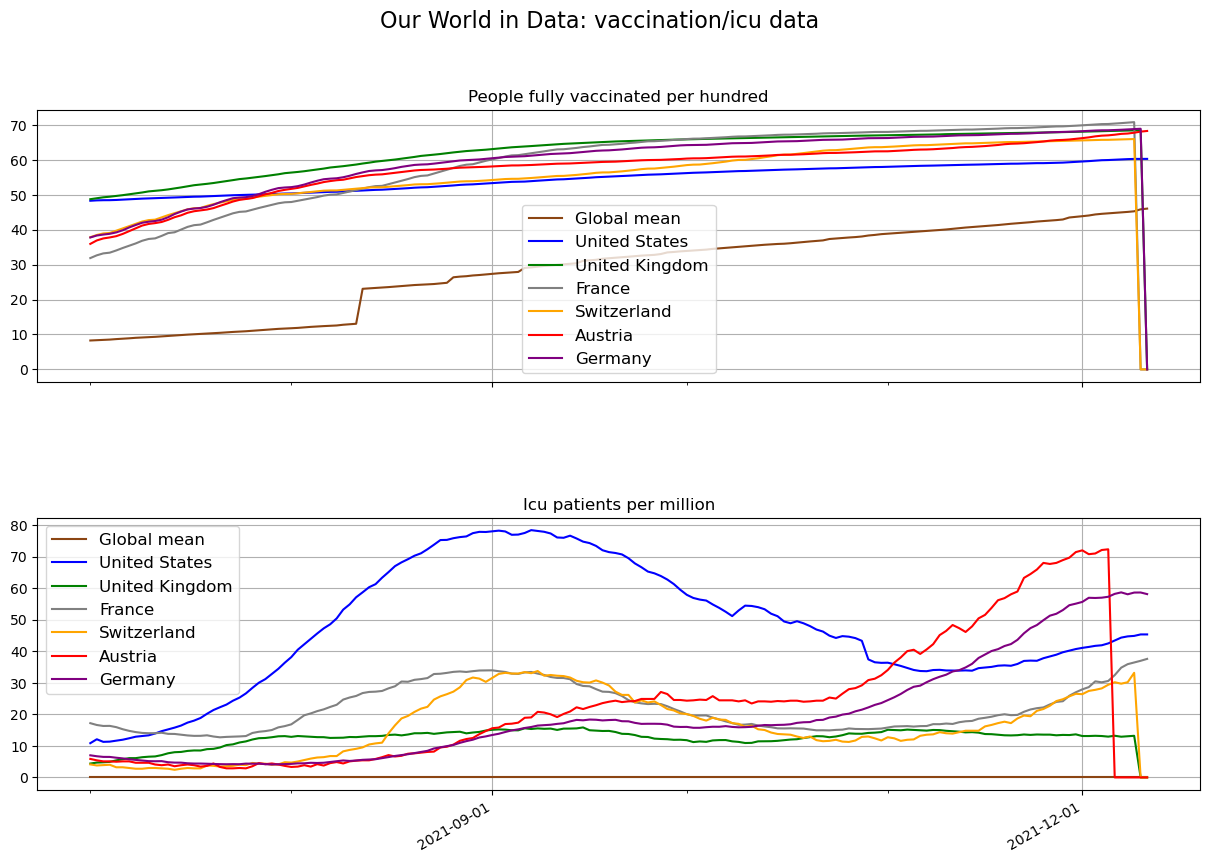

In [5]:
# re-juggle the data for a 2 country chart

# plot values
width = 15
height = 10
tsize = 16
fsize = 12
lsize = 10

# the countries being analyzed
yi_axis_values = 'USA'
yii_axis_values = 'GBR'
yiii_axis_values = 'FRA'
yiv_axis_values = 'CHE'
yv_axis_values = 'AUT'
yvi_axis_values = 'DEU'

yi_axis_label = data[yi_axis_values]['location']
yii_axis_label = data[yii_axis_values]['location']
yiii_axis_label = data[yiii_axis_values]['location']
yiv_axis_label = data[yiv_axis_values]['location']
yv_axis_label = data[yv_axis_values]['location']
yvi_axis_label = data[yvi_axis_values]['location']

# declare the axis vars
x_axis = []
yw1_axis = []
yw1_upper = []
yw1_lower = []
y1i_axis = []
y1ii_axis = []
y1iii_axis = []
y1iv_axis = []
y1v_axis = []
y1vi_axis = []

yw2_axis = []
yw2_upper = []
yw2_lower = []
y2i_axis = []
y2ii_axis = []
y2iii_axis = []
y2iv_axis = []
y2v_axis = []
y2vi_axis = []

# load the axis data lists
for key, val in date_dict.items():

    # list of dates for x axis
    x_axis.append(datetime.strptime(key, "%Y-%m-%d"))

    # lists of cases for y1 axis
    yw1_axis.append(val["wrl_val_1"])
    yw1_upper.append(val["stdev_upper_val_1"])
    yw1_lower.append(val["stdev_lower_val_1"])
    y1i_axis.append(val['country_vals'][yi_axis_values][0])
    y1ii_axis.append(val['country_vals'][yii_axis_values][0])
    y1iii_axis.append(val['country_vals'][yiii_axis_values][0])
    y1iv_axis.append(val['country_vals'][yiv_axis_values][0])
    y1v_axis.append(val['country_vals'][yv_axis_values][0])
    y1vi_axis.append(val['country_vals'][yvi_axis_values][0])

    
    # lists of deaths for y2 axis
    yw2_axis.append(val["wrl_val_2"])
    yw2_upper.append(val["stdev_upper_val_2"])
    yw2_lower.append(val["stdev_lower_val_2"])
    y2i_axis.append(val['country_vals'][yi_axis_values][1])
    y2ii_axis.append(val['country_vals'][yii_axis_values][1])
    y2iii_axis.append(val['country_vals'][yiii_axis_values][1])
    y2iv_axis.append(val['country_vals'][yiv_axis_values][1])
    y2v_axis.append(val['country_vals'][yv_axis_values][1])
    y2vi_axis.append(val['country_vals'][yvi_axis_values][1])

######################################################
# package up the matplotlib data for a 2 country chart
######################################################

# create the labels
chart_title_str = "Our World in Data: {} data".format(expl_str)
x_axis_label_str = "Date"

yw1_axis_legend_str = "Global mean"
yw1_stdev_legend_str = "Global std dev"
y1i_axis_legend_str = "{}".format(yi_axis_label)
y1ii_axis_legend_str = "{}".format(yii_axis_label)
y1iii_axis_legend_str = "{}".format(yiii_axis_label)
y1iv_axis_legend_str = "{}".format(yiv_axis_label)
y1v_axis_legend_str = "{}".format(yv_axis_label)
y1vi_axis_legend_str = "{}".format(yvi_axis_label)

yw2_axis_legend_str = "Global mean"
yw2_stdev_legend_str = "Global std dev"
y2i_axis_legend_str = "{}".format(yi_axis_label)
y2ii_axis_legend_str = "{}".format(yii_axis_label)
y2iii_axis_legend_str = "{}".format(yiii_axis_label)
y2iv_axis_legend_str = "{}".format(yiv_axis_label)
y2v_axis_legend_str = "{}".format(yv_axis_label)
y2vi_axis_legend_str = "{}".format(yvi_axis_label)


# define empty canvas
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(width, height))
fig.subplots_adjust(hspace = 0.5)

# declare the axis data
# subplot 1
ax1.set_title(descr_str_1, fontsize = fsize)
ax1.plot(x_axis, yw1_axis, label = yw1_axis_legend_str, color = 'saddlebrown')
ax1.grid()
#ax1.fill_between(x_axis, yw1_upper, yw1_lower, label = yw1_stdev_legend_str, color = 'yellow', alpha=0.5)
ax1.plot(x_axis, y1i_axis, label = y1i_axis_legend_str, color = 'blue')
ax1.plot(x_axis, y1ii_axis, label = y1ii_axis_legend_str, color = 'green')
ax1.plot(x_axis, y1iii_axis, label = y1iii_axis_legend_str, color = 'grey')
ax1.plot(x_axis, y1iv_axis, label = y1iv_axis_legend_str, color = 'orange')
ax1.plot(x_axis, y1v_axis, label = y1v_axis_legend_str, color = 'red')
ax1.plot(x_axis, y1vi_axis, label = y1vi_axis_legend_str, color = 'purple')

# subplot 2
ax2.set_title(descr_str_2, fontsize = fsize)
ax2.plot(x_axis, yw2_axis, label = yw2_axis_legend_str, color = 'saddlebrown')
ax2.grid()
#ax2.fill_between(x_axis, yw2_upper, yw2_lower, label = yw2_stdev_legend_str, color = 'yellow', alpha=0.5)
ax2.plot(x_axis, y2i_axis, label = y2i_axis_legend_str, color = 'blue')
ax2.plot(x_axis, y2ii_axis, label = y2ii_axis_legend_str, color = 'green')
ax2.plot(x_axis, y2iii_axis, label = y2iii_axis_legend_str, color = 'grey')
ax2.plot(x_axis, y2iv_axis, label = y2iv_axis_legend_str, color = 'orange')
ax2.plot(x_axis, y2v_axis, label = y2v_axis_legend_str, color = 'red')
ax2.plot(x_axis, y2vi_axis, label = y2vi_axis_legend_str, color = 'purple')


# declare the text data
fig.suptitle(chart_title_str, fontsize = tsize)

#  format the x axis (date) labels
# Text in the x axis will be displayed in 'YYYY-mm-dd' format.
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# major ticks every 3 months.
fmt_qtr_year = mdates.MonthLocator(interval = 3)
ax1.xaxis.set_major_locator(fmt_qtr_year)
ax2.xaxis.set_major_locator(fmt_qtr_year)

# minor ticks every month.
fmt_month = mdates.MonthLocator()
ax1.xaxis.set_minor_locator(fmt_month)
ax2.xaxis.set_minor_locator(fmt_month)

# Rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them.
fig.autofmt_xdate()

# changing the fontsize of ticks
ax1.tick_params(labelsize = lsize)
ax2.tick_params(labelsize = lsize)

# format the legends
ax1.legend(loc = 0, fontsize = fsize)
ax2.legend(loc = 0, fontsize = fsize)

# display the plot
plt.show()